In [ ]:
import copy
import datetime
import glob as glob
import heapq
import json
import math
import os
import time
import warnings
from collections import defaultdict, deque
from xml.etree import ElementTree as et

import albumentations as A
import cv2
import imghdr
import matplotlib.pyplot as plt
import numpy as np
import torch
from albumentations.pytorch import ToTensorV2
from google.colab.patches import cv2_imshow
from google.colab import drive
from PIL import Image
from pycocotools.coco import COCO
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset, random_split, sampler
from torchvision import datasets, models, transforms
from torchvision.transforms import functional as FT
from torchvision.utils import draw_bounding_boxes
from torchvision.ops.feature_pyramid_network import LastLevelMaxPool

from tqdm.auto import tqdm
from torch.utils.tensorboard import SummaryWriter
import torchvision


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
BATCH_SIZE = 4 # increase / decrease according to GPU memeory
NUM_EPOCHS = 65 # number of epochs to train for

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

DATASET_NAME = 'ITUv2'#'ITUv2'Oil Palm Trees
# training images and XML files directory
DATA_DIR = '/content/drive/MyDrive/'+DATASET_NAME
# classes: 0 index is reserved for background
CLASSES = [
    'tree-06Td', 'Tree'
]
NUM_CLASSES = 2

GROUND_TRUTH_PATH = DATA_DIR+'/valid/_annotations.coco.json'

OUT_DIR = DATA_DIR+'/exp'

# Check if the OUT_DIR exists
if not os.path.exists(OUT_DIR):
    os.makedirs(OUT_DIR)  # If not, create it
    exp_num = 1
else:
    # If it exists, find the next available experiment number
    exp_num = 1
    while os.path.exists(f"{OUT_DIR}_{exp_num}"):
        exp_num += 1
OUT_DIR = f"{OUT_DIR}_{exp_num}"
os.makedirs(OUT_DIR)  # Create the new experiment directory

# Create subdirectories inside the experiment directory
subdirectories = ['valid result', 'graph', 'test result']
for subdir in subdirectories:
    os.makedirs(os.path.join(OUT_DIR, subdir))
PREDICTIONS_FILE_PATH = OUT_DIR+'/predictions.json'

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
def get_train_transform():
    return A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))

# define the validation transforms
def get_valid_transform():
    return A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))

In [ ]:
#load classes
coco = COCO(os.path.join(DATA_DIR, "train", "_annotations.coco.json"))
categories = coco.cats
n_classes = len(categories.keys())
categories

loading annotations into memory...
Done (t=6.16s)
creating index...
index created!


{0: {'id': 0, 'name': 'tree-06Td', 'supercategory': 'none'},
 1: {'id': 1, 'name': 'Tree', 'supercategory': 'tree-06Td'}}

In [ ]:
class TreeDetection(datasets.VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None, transforms=None):
        # the 3 transform parameters are reuqired for datasets.VisionDataset
        super().__init__(root, transforms, transform, target_transform)
        self.split = split #train, valid, test
        self.coco = COCO(os.path.join(root, split, "_annotations.coco.json")) # annotatiosn stored here
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [id for id in self.ids if (len(self._load_target(id)) > 0)]

    def _load_image(self, id: int):
        path = self.coco.loadImgs(id)[0]['file_name']
        image = cv2.imread(os.path.join(self.root, self.split, path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image
    def _load_target(self, id):
        return self.coco.loadAnns(self.coco.getAnnIds(id))

    def __getitem__(self, index):
        id = self.ids[index]
        image = self._load_image(id)
        target = self._load_target(id)
        target = copy.deepcopy(self._load_target(id))

        boxes = [t['bbox'] + [t['category_id']] for t in target] # required annotation format for albumentations
        if self.transforms is not None:
            transformed = self.transforms(image=image, bboxes=boxes)

        image = transformed['image']
        boxes = transformed['bboxes']

        new_boxes = [] # convert from xywh to xyxy
        for box in boxes:
            xmin = box[0]
            xmax = xmin + box[2]
            ymin = box[1]
            ymax = ymin + box[3]
            new_boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.tensor(new_boxes, dtype=torch.float32)

        targ = {} # here is our transformed target
        targ['boxes'] = boxes
        targ['labels'] = torch.tensor([t['category_id'] for t in target], dtype=torch.int64)
        targ['image_id'] = torch.tensor([t['image_id'] for t in target])
        targ['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) # we have a different area
        targ['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype=torch.int64)
        return image.div(255), targ # scale images
    def __len__(self):
        return len(self.ids)

In [ ]:
# prepare the final datasets and data loaders
train_dataset = TreeDetection(root=DATA_DIR, transforms=get_train_transform())
valid_dataset = TreeDetection(root=DATA_DIR, split="valid",transforms=get_valid_transform())
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, collate_fn=collate_fn)
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(valid_dataset)}\n")

loading annotations into memory...
Done (t=0.71s)
creating index...
index created!
loading annotations into memory...
Done (t=1.42s)
creating index...
index created!
Number of training samples: 1023
Number of validation samples: 223



In [ ]:
classes = [i[1]['name'] for i in categories.items()]
classes

['tree-06Td', 'Tree']

<ipython-input-10-05b4a4f2abc9>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img_int = torch.tensor(sample[0] * 255, dtype=torch.uint8)


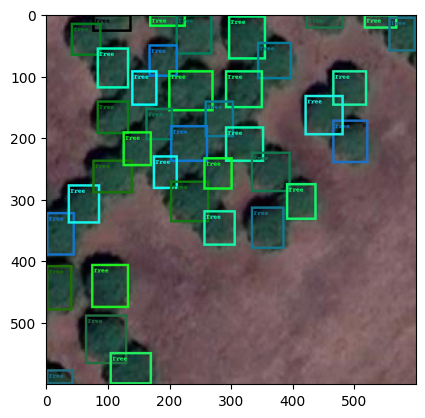

In [ ]:
# Lets view a sample
sample = train_dataset[10]
img_int = torch.tensor(sample[0] * 255, dtype=torch.uint8)
plt.imshow(draw_bounding_boxes(
    img_int, sample[1]['boxes'], [classes[i] for i in sample[1]['labels']], width=4
).permute(1, 2, 0))

# **MobileNet V3 + ResNet101 BACKBONE FASTERCNN**

In [ ]:
import torch
import torch.nn as nn
from torchvision import models
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

class CombinedMobileNetV3ResNet101(nn.Module):
    def __init__(self):
        super(CombinedMobileNetV3ResNet101, self).__init__()
        # Load pretrained MobileNetV3 and ResNet101
        self.mobilenet_v3 = models.mobilenet_v3_large(pretrained=False)
        self.resnet101 = models.resnet101(pretrained=False)

        # Using the feature part of MobileNetV3 and not the classifier
        self.mobilenet_features = self.mobilenet_v3.features

        # Using everything up to the last layer in ResNet101
        self.resnet_features = nn.Sequential(*list(self.resnet101.children())[:-2])

        # Dimensionality reduction layer after combining features
        self.dim_reduction = nn.Conv2d(960 + 2048, 512, kernel_size=1)  # Correct the input channels

    def forward(self, x):
        # Extract features from both models
        features_mobilenet = self.mobilenet_features(x)
        features_resnet = self.resnet_features(x)

        # Resize feature maps to the same size if needed
        features_resnet = nn.functional.adaptive_avg_pool2d(features_resnet, output_size=(features_mobilenet.shape[2], features_mobilenet.shape[3]))

        # Concatenate the features
        combined_features = torch.cat((features_mobilenet, features_resnet), dim=1)

        # Apply dimensionality reduction
        reduced_features = self.dim_reduction(combined_features)
        return reduced_features

def create_model(num_classes):
    # Instantiate the custom backbone
    backbone = CombinedMobileNetV3ResNet101()
    backbone.out_channels = 512  # Set the number of output channels of the last layer of the backbone

    # Create an anchor generator for Faster R-CNN
    anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                       aspect_ratios=((0.5, 1.0, 2.0),))

    # Construct the model using the custom backbone
    model = FasterRCNN(backbone=backbone,
                       num_classes=num_classes,
                       rpn_anchor_generator=anchor_generator)
    return model


# **ResNET101 BACKBONE FASTERCNN**

In [ ]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def create_model(num_classes):
    # Load a pre-trained ResNet-101 model as the backbone with FPN
    backbone = resnet_fpn_backbone('resnet101', pretrained=True)

    # Create the Faster R-CNN model using the ResNet-101 FPN backbone
    model = FasterRCNN(backbone, num_classes=num_classes)

    # Replace the pre-trained head with a new one
    # Note: in Faster R-CNN, the classifier's input features come from the box predictor
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [ ]:
def train(train_data_loader, model, optimizer, device):
    print('Training')
    train_loss = 0.0

    prog_bar = tqdm(train_data_loader, total=len(train_data_loader))
    model.train()

    for i, data in enumerate(prog_bar):
        optimizer.zero_grad()
        images, targets = data

        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass
        loss_dict = model(images, targets)

        # Check and handle the output format
        if isinstance(loss_dict, dict):
            losses = sum(loss for loss in loss_dict.values())
        else:
            # Handle the case if loss_dict is not a dictionary
            print("Unexpected format of loss_dict")
            continue

        loss_value = losses.item()
        train_loss += loss_value

        # Backward pass
        losses.backward()
        optimizer.step()

        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")

    return train_loss / len(train_data_loader)

In [ ]:
# Function to calculate Intersection over Union (IoU)
def iou(box1, box2):
    x_left = max(box1[0], box2[0])
    y_top = max(box1[1], box2[1])
    x_right = min(box1[0] + box1[2], box2[0] + box2[2])
    y_bottom = min(box1[1] + box1[3], box2[1] + box2[3])
    intersection_area = max(0, x_right - x_left) * max(0, y_bottom - y_top)
    box1_area = box1[2] * box1[3]
    box2_area = box2[2] * box2[3]
    union_area = box1_area + box2_area - intersection_area
    return intersection_area / float(union_area)

# Function to prepare data for mAP computation
def prepare_data(ground_truth, predictions):
    gt_data = defaultdict(list)
    pred_data = defaultdict(list)
    for item in ground_truth['annotations']:
        gt_data[item['image_id']].append({
            'bbox': item['bbox'],
            'category_id': item['category_id']
        })
    for item in predictions:
        pred_data[item['image_id']].append({
            'bbox': item['bbox'],
            'category_id': item['category_id'],
            'score': item['score']
        })
    return gt_data, pred_data

# Function to calculate precision and recall
def calculate_precision_recall_iou(gt_data, pred_data, iou_threshold):
    precisions = []
    recalls = []
    for image_id in gt_data.keys():
        gt_boxes = gt_data[image_id]
        pred_boxes = sorted(pred_data[image_id], key=lambda x: x['score'], reverse=True)
        TP = FP = 0
        gt_detected = [False] * len(gt_boxes)
        for pred_box in pred_boxes:
            matched = False
            for i, gt_box in enumerate(gt_boxes):
                if not gt_detected[i] and iou(pred_box['bbox'], gt_box['bbox']) >= iou_threshold:
                    TP += 1
                    gt_detected[i] = True
                    matched = True
                    break
            if not matched:
                FP += 1
        FN = len(gt_boxes) - sum(gt_detected)
        precision = TP / (TP + FP) if TP + FP > 0 else 0
        recall = TP / (TP + FN) if TP + FN > 0 else 0
        precisions.append(precision)
        recalls.append(recall)
    return precisions, recalls

# Function to calculate Average Precision (AP)
def calculate_average_precision(precisions, recalls):
    recall_precision_pairs = sorted(zip(recalls, precisions))
    sorted_recalls, sorted_precisions = zip(*recall_precision_pairs)
    precision_envelope = np.maximum.accumulate(sorted_precisions[::-1])[::-1]
    recall_steps = np.linspace(0, 1, 101)
    integrated_precision = np.zeros_like(recall_steps)
    j = 0
    for i, recall_step in enumerate(recall_steps):
        while j < len(sorted_recalls) and sorted_recalls[j] < recall_step:
            j += 1
        integrated_precision[i] = precision_envelope[j - 1] if j > 0 else 0
    return integrated_precision.mean()

# Function to calculate mAP at different IoU thresholds
def calculate_map_at_iou_thresholds(gt_data, pred_data, iou_thresholds):
    ap_scores = []
    for iou_threshold in iou_thresholds:
        precisions, recalls = calculate_precision_recall_iou(gt_data, pred_data, iou_threshold)
        average_precision = calculate_average_precision(precisions, recalls)
        ap_scores.append(average_precision)
    return ap_scores

In [ ]:
def generate_predictions(model_path, test_images_dir, detection_threshold=0.6):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    # Load the model
    model = create_model(num_classes=2).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    # List to store predictions
    all_predictions = []
    test_images = glob.glob(f"{test_images_dir}/*")

    for i, image_path in enumerate(test_images):
        if not os.path.exists(image_path):
            print(f"Image path does not exist: {image_path}")
            continue
        if imghdr.what(image_path) is None:
            continue

        image = cv2.imread(image_path)
        orig_image = image.copy()
        image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        image = torch.tensor(image, dtype=torch.float).to(device)
        image = torch.unsqueeze(image, 0)

        with torch.no_grad():
            outputs = model(image)

        if len(outputs[0]['boxes']) != 0:
            boxes = outputs[0]['boxes'].cpu().numpy()
            scores = outputs[0]['scores'].cpu().numpy()
            labels = outputs[0]['labels'].cpu().numpy()

            for box, score, label in zip(boxes, scores, labels):
                if score >= detection_threshold:
                    box = box.tolist()
                    score = float(score)  # Fix here
                    label = int(label)
                    # Convert box coordinates to [x, y, width, height]
                    box[2] -= box[0]
                    box[3] -= box[1]
                    prediction = {
                        "image_id": i,
                        "category_id": CLASSES[label],  # Define or import CLASSES
                        "bbox": box,
                        "score": score
                    }
                    all_predictions.append(prediction)

    # Save predictions to a JSON file
    with open(PREDICTIONS_FILE_PATH, 'w') as file:
        json.dump(all_predictions, file)

    return PREDICTIONS_FILE_PATH


In [ ]:
def validate(valid_data_loader, model, device):
    print('Validating')
    val_loss_list = []
    prog_bar = tqdm(valid_data_loader, total=len(valid_data_loader))

    for data in prog_bar:
        images, targets = data
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        with torch.no_grad():
            loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        val_loss_list.append(loss_value)
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")

    avg_val_loss = sum(val_loss_list) / len(val_loss_list)
    return avg_val_loss

In [ ]:
def main():
    model = create_model(num_classes=NUM_CLASSES).to(DEVICE)
    print(model)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.0005, momentum=0.9, weight_decay=0.0005)
    writer = SummaryWriter(OUT_DIR)

    patience = 60
    reduce_lr_patience = 5
    factor = 0.1
    min_lr = 5e-7
    best_map_score = 0
    epochs_no_improve = 0
    epochs_no_improve_lr = 0

    with open(GROUND_TRUTH_PATH, 'r') as file:
        ground_truth_data = json.load(file)

    best_val_loss = float('inf')  # Initialize best validation loss as infinity
    best_val_model_path = ""  # Path to save the best model based on validation loss

    top40_models = []  # To store the top 5 models (as a min heap)
    top30_models = []
    for epoch in range(NUM_EPOCHS):
        train_loss = train(train_loader, model, optimizer, DEVICE)
        val_loss = validate(valid_loader, model, DEVICE)

        # Generate predictions using the current model state
        current_model_path = f"{OUT_DIR}/model_epoch_{epoch+1}.pth"
        torch.save(model.state_dict(), current_model_path)
        PREDICTIONS_FILE_PATH = generate_predictions(current_model_path, DATA_DIR+'/valid')

        with open(PREDICTIONS_FILE_PATH, 'r') as predictions_file:
            predictions_data = json.load(predictions_file)

        gt_data, pred_data = prepare_data(ground_truth_data, predictions_data)
        iou_thresholds = [0.25, 0.50, 0.75]
        map_scores = calculate_map_at_iou_thresholds(gt_data, pred_data, iou_thresholds)
        iou_thresholds_map_50_95 = np.arange(0.50, 1.0, 0.05)
        map_50_95_scores = calculate_map_at_iou_thresholds(gt_data, pred_data, iou_thresholds_map_50_95)
        map_50_95 = np.mean(map_50_95_scores)
        # Print MAP scores
        print("MAP scores at IOU thresholds:")
        for iou, map_score in zip(iou_thresholds_map_50_95, map_50_95_scores):
            print(f"IOU: {iou:.2f}, MAP: {map_score:.5f}")

        # Log the metrics to TensorBoard
        writer.add_scalar('Training Loss', train_loss, epoch)
        writer.add_scalar('Validation Loss', val_loss, epoch)
        writer.add_scalar('mAP@25', map_scores[0], epoch)
        writer.add_scalar('mAP@50', map_scores[1], epoch)
        writer.add_scalar('mAP@75', map_scores[2], epoch)
        writer.add_scalar('mAP@50:95', map_50_95, epoch)

        # Update best model based on mAP score
        if (len(top40_models) < 10 or map_50_95 > top40_models[0][0]) and epoch > 9 and map_50_95 > 0.4:

            model_path = f"{OUT_DIR}/model_epoch_{epoch+1}_map_{map_50_95:.4f}.pth"
            torch.save(model.state_dict(), model_path)

            if len(top40_models) == 10:
                  # Remove the model with the lowest mAP score
                os.remove(os.path.join(OUT_DIR, heapq.heappop(top40_models)[1]))
            heapq.heappush(top40_models, (map_50_95, os.path.basename(model_path)))


        if (len(top30_models) < 10 or map_50_95 > top30_models[0][0]) and epoch > 9 and (map_50_95 < 0.4 and map_50_95 > 0.3):
              model_path = f"{OUT_DIR}/model_epoch_{epoch+1}_map_{map_50_95:.4f}.pth"
              torch.save(model.state_dict(), model_path)

              if len(top30_models) == 10:
                  # Remove the model with the lowest mAP score
                  os.remove(os.path.join(OUT_DIR, heapq.heappop(top30_models)[1]))
              heapq.heappush(top30_models, (map_50_95, os.path.basename(model_path)))
        # Update best model based on validation loss
        if val_loss < best_val_loss:
            epochs_no_improve = 0
            epochs_no_improve_lr = 0
            best_val_loss = val_loss  # Update the best validation loss
            # Remove the previous best model to save space, if desired
            if best_val_model_path:
                os.remove(best_val_model_path)
            # Save the new best model
            best_val_model_path = f"{OUT_DIR}/best_val_model_epoch_{epoch+1}_loss_{val_loss:.4f}.pth"
            torch.save(model.state_dict(), best_val_model_path)
            print(f"New best model saved with validation loss: {val_loss:.4f}")
        else:
            epochs_no_improve += 1
            epochs_no_improve_lr += 1

        # Early stopping and learning rate reduction logic
        if epochs_no_improve == patience:
            print("Early stopping triggered")
            break

        if epochs_no_improve_lr == reduce_lr_patience:
            old_lr = optimizer.param_groups[0]['lr']
            new_lr = max(old_lr * factor, min_lr)
            if new_lr < old_lr:
                print(f"Reducing learning rate from {old_lr} to {new_lr}.")
                optimizer.param_groups[0]['lr'] = new_lr
                epochs_no_improve_lr = 0
            else:
                epochs_no_improve_lr += 1

        print(f"Epoch [{epoch + 1}/{NUM_EPOCHS}] - Train Loss: {train_loss:.5f}, Val Loss: {val_loss:.5f}, mAP Scores: [25: {map_scores[0]:.5f}, 50: {map_scores[1]:.5f}, 75: {map_scores[2]:.5f}, 50-95: {map_50_95:.5f}]")
    writer.close()

if __name__ == '__main__':
    main()

In [ ]:
# directory where all the images are present
DIR_TEST = '/content/drive/MyDrive/ITUv2/test'
test_images = glob.glob(f"{DIR_TEST}/*")
print(f"Test instances: {len(test_images)}")

# classes: 0 index is reserved for background


# define the detection threshold...
# ... any detection having score below this will be discarded
detection_threshold = 0.8

In [ ]:

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# Load the model and the trained weights

model = create_model(num_classes=NUM_CLASSES).to(DEVICE)
model.load_state_dict(torch.load('/content/drive/MyDrive/ITUv2/exp_6(RESNET101)/best_val_model_epoch_63_loss_0.5499.pth', map_location=device))
print(model)

model.eval()

# List to store predictions
all_predictions = []

for i in range(len(test_images)):
    image_path = test_images[i]

    # Check if the image path exists and is a valid image
    if not os.path.exists(image_path):
        print(f"Image path does not exist: {image_path}")
        continue
    if imghdr.what(image_path) is None:
        print(f"The file is not a valid image: {image_path}")
        continue

    # Read the image
    try:
        image = cv2.imread(image_path)
        orig_image = image.copy()
    except AttributeError as e:
        print(f"Could not process the image at: {image_path}")
        print(f"Error: {e}")
        continue

    # Image processing
    image_name = test_images[i].split('/')[-1].split('.')[0]
    image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB).astype(np.float32)
    image /= 255.0
    image = np.transpose(image, (2, 0, 1)).astype(float)

    image = torch.tensor(image, dtype=torch.float).cuda()
    image = torch.unsqueeze(image, 0)
    with torch.no_grad():
        outputs = model(image)

    # load all detection to CPU for further operations
    outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]
    # Carry further only if there are detected boxes
    if len(outputs[0]['boxes']) != 0:
        boxes = outputs[0]['boxes'].data.numpy()
        scores = outputs[0]['scores'].data.numpy()
        # Filter out boxes according to `detection_threshold`
        boxes = boxes[scores >= detection_threshold].astype(np.int32)
        draw_boxes = boxes.copy()
        # Get all the predicted class names
        pred_classes = [CLASSES[i] for i in outputs[0]['labels'].cpu().numpy()]

        # Create predictions for the current image
        image_id = i + 1  # Assuming image IDs start from 1
        image_predictions = []

        # Draw the bounding boxes and write the class name on top of it
        for j, box in enumerate(draw_boxes):
            if j < len(scores):  # Check if the index is within the valid range
                score_text = f"{scores[j]:.3f}"
                prediction = {
                    "image_id": image_id,
                    "category_id": pred_classes[j],  # Assuming category_id corresponds to class names
                    "bbox": [float(box[0]), float(box[1]), float(box[2] - box[0]), float(box[3] - box[1])],
                    "score": float(scores[j])
                }
                image_predictions.append(prediction)

                # Display the image with predictions (optional)
                cv2.rectangle(orig_image,
                              (int(box[0]), int(box[1])),
                              (int(box[2]), int(box[3])),
                              (0, 0, 255), 2)
                cv2.putText(orig_image, f"{score_text}",
                            (int(box[0]), int(box[1] - 5)),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1,
                            lineType=cv2.LINE_AA)

        cv2_imshow(orig_image)
        cv2.imwrite(OUT_DIR+f"/valid result/{image_name}.jpg", orig_image)
        all_predictions.extend(image_predictions)

        print(f"Image {i+1} done...")
        print('-'*50)

# Write all predictions to a JSON file
with open(OUT_DIR+"/valid result/predictions1.json", 'w') as json_file:
    json.dump(all_predictions, json_file)

print('Prediction JSON file created!')


In [ ]:

# directory where all the images are present
DIR_TEST1 = '/content/drive/MyDrive/PalmTree/test'
test_images = glob.glob(f"{DIR_TEST1}/*")
print(f"Test instances: {len(test_images)}")

# classes: 0 index is reserved for background


# define the detection threshold...
# ... any detection having score below this will be discarded
detection_threshold = 0.6

In [ ]:
import json
from google.colab.patches import cv2_imshow
import imghdr
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# Load the model and the trained weights
model = create_model(num_classes=2).to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/PalmTree/output/best_val_model_epoch_171_loss_0.1445.pth', map_location=device))
model.eval()

# List to store predictions
all_predictions = []

for i in range(len(test_images)):
    image_path = test_images[i]

    # Check if the image path exists and is a valid image
    if not os.path.exists(image_path):
        print(f"Image path does not exist: {image_path}")
        continue
    if imghdr.what(image_path) is None:
        print(f"The file is not a valid image: {image_path}")
        continue

    # Read the image
    try:
        image = cv2.imread(image_path)
        orig_image = image.copy()
    except AttributeError as e:
        print(f"Could not process the image at: {image_path}")
        print(f"Error: {e}")
        continue

    # Image processing
    image_name = test_images[i].split('/')[-1].split('.')[0]
    image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB).astype(np.float32)
    image /= 255.0
    image = np.transpose(image, (2, 0, 1)).astype(np.float)
    image = torch.tensor(image, dtype=torch.float).cuda()
    image = torch.unsqueeze(image, 0)
    with torch.no_grad():
        outputs = model(image)

    # load all detection to CPU for further operations
    outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]
    # Carry further only if there are detected boxes
    if len(outputs[0]['boxes']) != 0:
        boxes = outputs[0]['boxes'].data.numpy()
        scores = outputs[0]['scores'].data.numpy()
        # Filter out boxes according to `detection_threshold`
        boxes = boxes[scores >= detection_threshold].astype(np.int32)
        draw_boxes = boxes.copy()
        # Get all the predicted class names
        pred_classes = [CLASSES[i] for i in outputs[0]['labels'].cpu().numpy()]

        # Create predictions for the current image
        image_id = i + 1  # Assuming image IDs start from 1
        image_predictions = []

        # Draw the bounding boxes and write the class name on top of it
        for j, box in enumerate(draw_boxes):
            if j < len(scores):  # Check if the index is within the valid range
                score_text = f"{scores[j]:.3f}"
                prediction = {
                    "image_id": image_id,
                    "category_id": pred_classes[j],  # Assuming category_id corresponds to class names
                    "bbox": [float(box[0]), float(box[1]), float(box[2] - box[0]), float(box[3] - box[1])],
                    "score": float(scores[j])
                }
                image_predictions.append(prediction)

                # Display the image with predictions (optional)
                cv2.rectangle(orig_image,
                              (int(box[0]), int(box[1])),
                              (int(box[2]), int(box[3])),
                              (0, 0, 255), 2)
                cv2.putText(orig_image, f"{score_text}",
                            (int(box[0]), int(box[1] - 5)),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1,
                            lineType=cv2.LINE_AA)

        cv2_imshow(orig_image)
        cv2.imwrite(OUT_DIR+f"/test result/{image_name}.jpg", orig_image)
        all_predictions.extend(image_predictions)

        print(f"Image {i+1} done...")
        print('-'*50)

# Write all predictions to a JSON file
with open(OUT_DIR+"/test result/predictions.json", 'w') as json_file:
    json.dump(all_predictions, json_file)

print('Prediction JSON file created!')


In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

# Start TensorBoard within the notebook using the directory where logs are stored
%tensorboard --logdir /content/drive/MyDrive/PalmTree/output

In [ ]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt
import numpy as np

def smooth(scalars, weight=0.6):  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (presumably at step 0)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value
    return smoothed

# Path to your TensorBoard log file
log_file_path = ''

# Path to save the exported graphs
exported_graph_dir = '/content/drive/MyDrive/ITUv2/exp_3(RESNET101+MOBILENETV3)/graph_manipulated/'

from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt
import numpy as np

# Your smoothing function here

# Initialize the event accumulator with no size limit on the scalars to be loaded
event_acc = EventAccumulator(log_file_path, size_guidance={'scalars': 0})
event_acc.Reload()

# Get all scalar tags
scalars = event_acc.Tags()['scalars']
print('Scalars found:', scalars)  # Verbose output

for scalar in scalars:
    # Convert scalar name to lowercase for case-insensitive comparison
    # Now we're checking for both 'loss' and 'map' in the scalar names
    if 'loss' in scalar.lower() or 'map' in scalar.lower():
        print('Processing:', scalar)  # Verbose output
        events = event_acc.Scalars(scalar)
        steps = [e.step for e in events]
        values = [e.value for e in events]
        smoothed_values = smooth(values, weight=0.6)

        plt.figure(figsize=(10, 5))
        plt.plot(steps, values, label=scalar, alpha=0.3)  # Original line with less opacity
        plt.plot(steps, smoothed_values, label=f'{scalar} (smoothed)', alpha=1.0)  # Smoothed line with full opacity
        plt.xlabel('Steps')
        plt.ylabel(scalar)
        plt.title(f'{scalar} over Training Steps')
        plt.legend()
        plt.grid(True)

        # Save the plot
        plot_filename = f'{exported_graph_dir}{scalar.replace(" ", "_").replace(":", "_")}_smoothednew_plot.png'
        plt.savefig(plot_filename)
        print('Plot saved to:', plot_filename)  # Verbose output
        plt.close()  # Close the figure to free memory
    else:
        print('Skipping:', scalar)  # Verbose output


Scalars found: ['Training Loss', 'Validation Loss', 'mAP@25', 'mAP@50', 'mAP@75', 'mAP@50:95']
Processing: Training Loss
Plot saved to: /content/drive/MyDrive/ITUv2/exp_6(MOBILENETV3)/graph/Training_Loss_smoothednew_plot.png
Processing: Validation Loss
Plot saved to: /content/drive/MyDrive/ITUv2/exp_6(MOBILENETV3)/graph/Validation_Loss_smoothednew_plot.png
Processing: mAP@25
Plot saved to: /content/drive/MyDrive/ITUv2/exp_6(MOBILENETV3)/graph/mAP@25_smoothednew_plot.png
Processing: mAP@50
Plot saved to: /content/drive/MyDrive/ITUv2/exp_6(MOBILENETV3)/graph/mAP@50_smoothednew_plot.png
Processing: mAP@75
Plot saved to: /content/drive/MyDrive/ITUv2/exp_6(MOBILENETV3)/graph/mAP@75_smoothednew_plot.png
Processing: mAP@50:95
Plot saved to: /content/drive/MyDrive/ITUv2/exp_6(MOBILENETV3)/graph/mAP@50_95_smoothednew_plot.png
